# Self made RP3-beta

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read = pd.read_csv("./Datasets/ml-100k/train.csv", sep="\t", header=None)
test_read = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)
(
    train_ui,
    test_ui,
    user_code_id,
    user_id_code,
    item_code_id,
    item_id_code,
) = helpers.data_to_csr(train_read, test_read)

In [2]:
class RP3Beta:
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui = train_ui
        self.train_iu = train_ui.transpose()

        self.alpha = alpha
        self.beta = beta

        # Define Pui
        Pui = sparse.csr_matrix(self.train_ui / self.train_ui.sum(axis=1))

        # Define Piu
        to_divide = np.vectorize(lambda x: x if x > 0 else 1)(
            self.train_iu.sum(axis=1)
        )  # to avoid dividing by zero
        Piu = sparse.csr_matrix(self.train_iu / to_divide)
        item_orders = (self.train_ui > 0).sum(axis=0)

        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3 = Pui * Piu * Pui 

        P3 /= np.power(
            np.vectorize(lambda x: x if x > 0 else 1)(item_orders), self.beta
        )

        self.estimations = np.array(P3)

    def recommend(self, user_code_id, item_code_id, topK=10):

        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):

            user_rated = self.train_ui.indices[
                self.train_ui.indptr[nb_user] : self.train_ui.indptr[nb_user + 1]
            ]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result

    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append(
                [
                    user_code_id[user],
                    item_code_id[item],
                    self.estimations[user, item]
                    if not np.isnan(self.estimations[user, item])
                    else 1,
                ]
            )
        return result

In [3]:
model = RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [4]:
top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_P3_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv",
    index=False,
    header=False,
)

In [5]:
import evaluation_measures as ev

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 12434.93it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR  HitRate2  HitRate3  Reco in test  Test coverage   Shannon  \
0  0.875928  0.685048  0.495228           1.0       0.077201  3.875892   

       Gini  
0  0.974947

# Let's check hyperparameters

##### Alpha

In [6]:
from tqdm import tqdm

result = []
for alpha in tqdm([round(i, 1) for i in np.arange(0.2, 1.6001, 0.2)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)

result = pd.concat(result)
result

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]
943it [00:00, 13897.79it/s]
 12%|██████████▌                                                                         | 1/8 [00:06<00:42,  6.02s/it]
943it [00:00, 13501.01it/s]
 25%|█████████████████████                                                               | 2/8 [00:11<00:35,  5.97s/it]
943it [00:00, 12601.73it/s]
 38%|███████████████████████████████▌                                                    | 3/8 [00:17<00:29,  5.99s/it]
943it [00:00, 12158.08it/s]
 50%|██████████████████████████████████████████                                          | 4/8 [00:24<00:24,  6.05s/it]
943it [00:00, 12607.07it/s]
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:30<00:18,  6.12s/it]
943it [00:00, 13126.43it/s]
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:36<00:12,  6.

Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR  HitRate2  HitRate3  Reco in test  Test coverage   Shannon  \
0  0.850477  0.629905  0.451750      1.000000       0.060606  3.669627   
0  0.854719  0.644751  0.458112      1.000000       0.064214  3.726996   
0  0.870626  0.657476  0.470838      1.000000       0.065657  3.785282   
0  0.874867  0.685048  0.492047      1.000000       0.070707  3.832415   
0  0.875928  0.685048  0.495228      1.000000       0.077201  3.875892   
0  0.883351  0.681866  0.498409      1.000000       0.085859  3.910718   
0  0.871686  0.675504  0.489926      1.000000       0.107504  3.961915   
0  0.868505  0.669141  0.462354      0.999576       0.156566  4.060156   

       Gini  
0  0.979636  
0  0.978426  
0  0.977090  
0  0.975998  
0  0.974947  
0  0.974073  
0  0.972674  
0  0.969203

IndexError: list index out of range

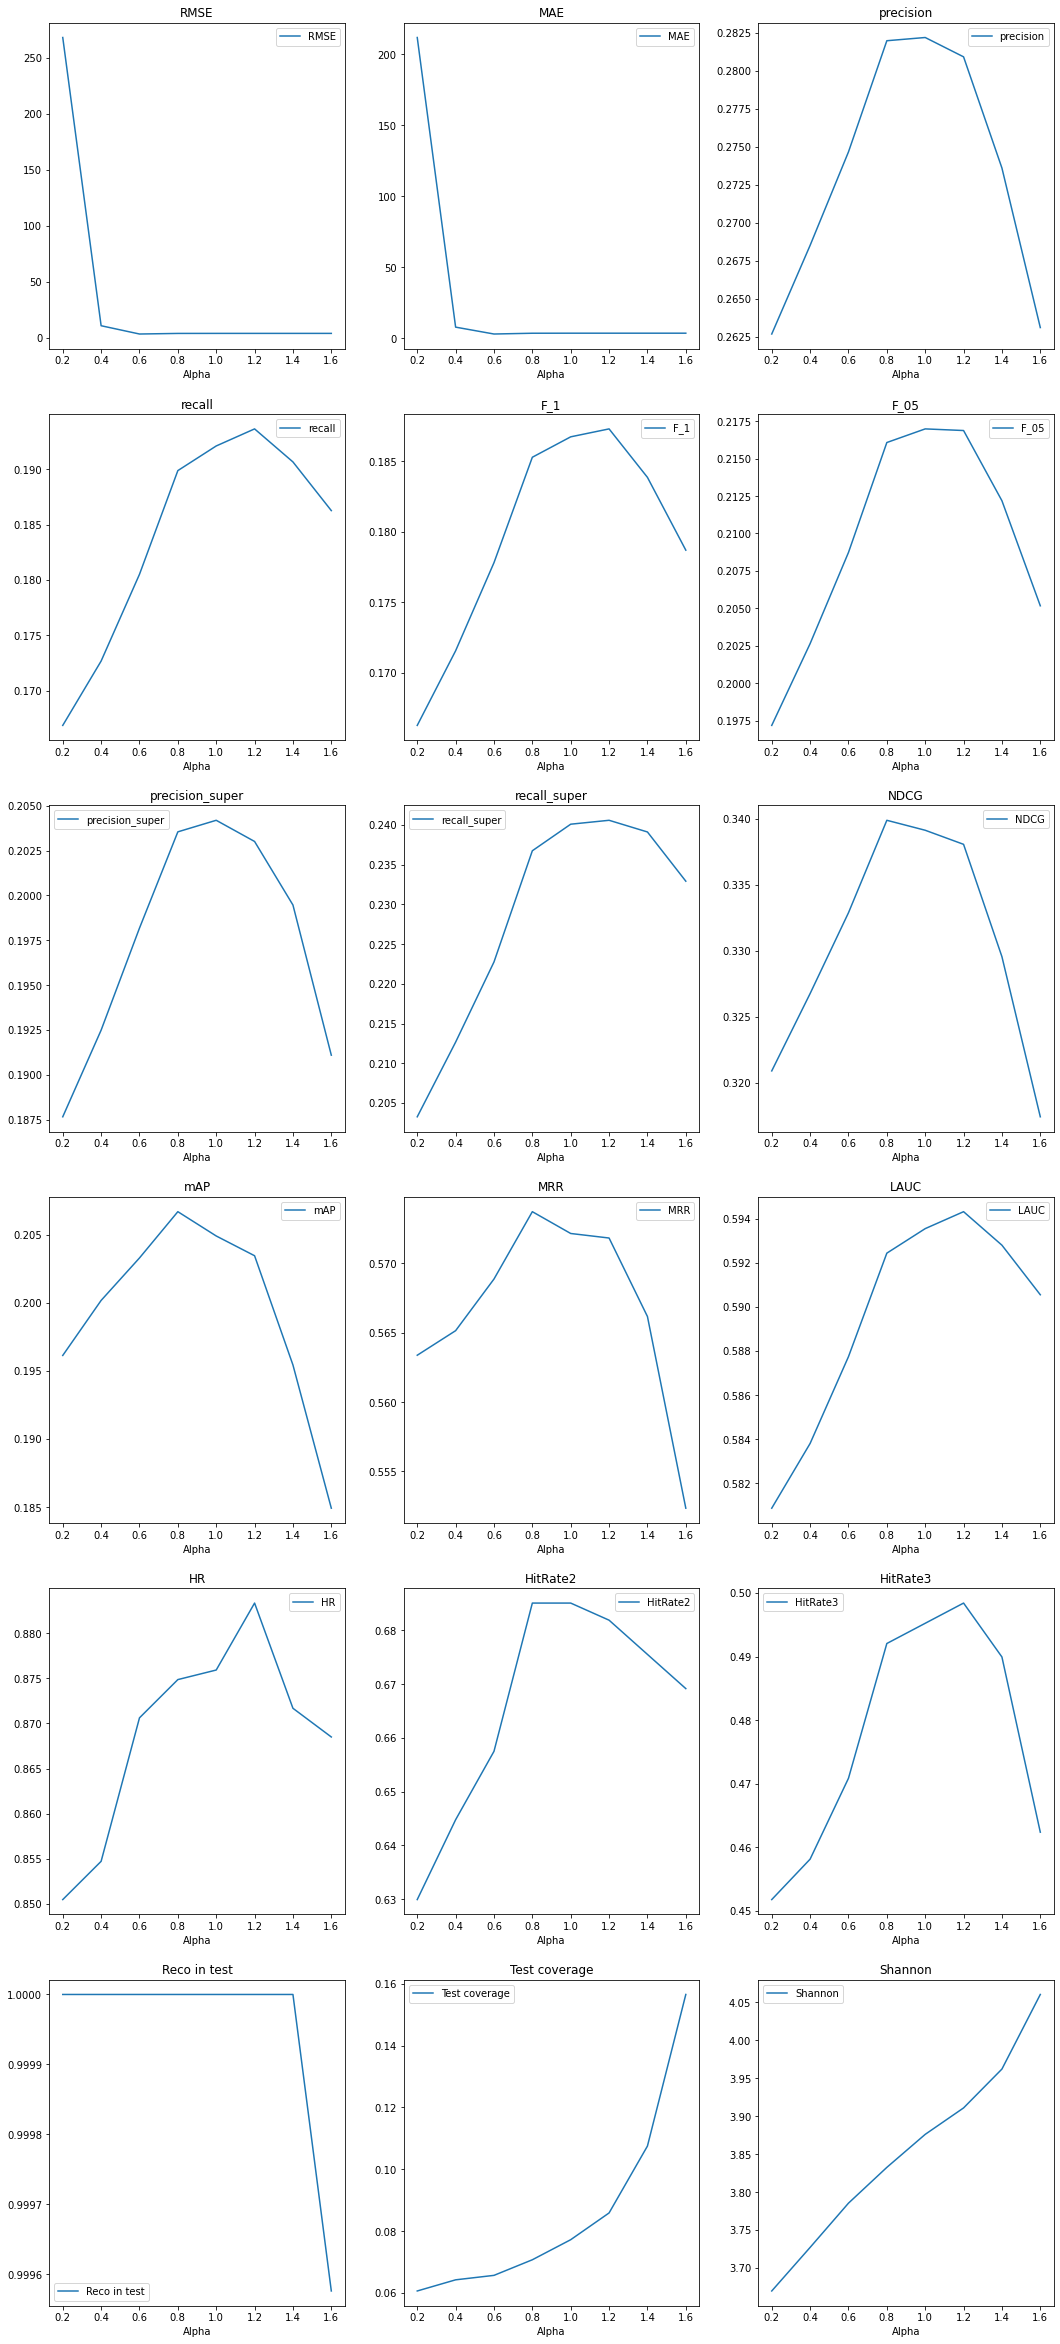

In [7]:
metrics = list(result.columns[[i not in ["Alpha"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Alpha", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [8]:
from tqdm import tqdm

result = []
for beta in tqdm([round(i, 1) for i in np.arange(0, 1, 0.1)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Beta", beta)
    result.append(to_append)

result = pd.concat(result)
result

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]
943it [00:00, 12120.56it/s]
 10%|████████▎                                                                          | 1/10 [00:06<00:54,  6.01s/it]
943it [00:00, 12283.97it/s]
 20%|████████████████▌                                                                  | 2/10 [00:12<00:48,  6.06s/it]
943it [00:00, 12771.78it/s]
 30%|████████████████████████▉                                                          | 3/10 [00:18<00:42,  6.03s/it]
943it [00:00, 13126.91it/s]
 40%|█████████████████████████████████▏                                                 | 4/10 [00:24<00:36,  6.05s/it]
943it [00:00, 12952.63it/s]
 50%|█████████████████████████████████████████▌                                         | 5/10 [00:30<00:30,  6.09s/it]
943it [00:00, 13132.62it/s]
 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:36<00:24,  6.

Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR  HitRate2  HitRate3  Reco in test  Test coverage   Shannon  \
0  0.875928  0.685048  0.495228      1.000000       0.077201  3.875892   
0  0.884411  0.695652  0.514316      1.000000       0.085137  3.957416   
0  0.886532  0.697773  0.515376      1.000000       0.094517  4.053212   
0  0.888653  0.707317  0.531283      1.000000       0.105339  4.147779   
0  0.895016  0.718982  0.537646      0.999894       0.132035  4.259682   
0  0.903499  0.724284  0.548250      0.999046       0.168831  4.411281   
0  0.897137  0.720042  0.542948      0.996394       0.212843  4.621938   
0  0.868505  0.693531  0.520679      0.983033       0.256854  4.898568   
0  0.803818  0.604454  0.428420      0.936373       0.341270  5.257397   
0  0.580064  0.400848  0.261930      0.800106       0.415584  5.563910   

       Gini  
0  0.974947  
0  0.972784  
0  0.969980  
0  0.966948  
0  0.962989  
0  0.956648  
0  0.945932  
0  0.928065  
0  0.895882  
0  0.857396

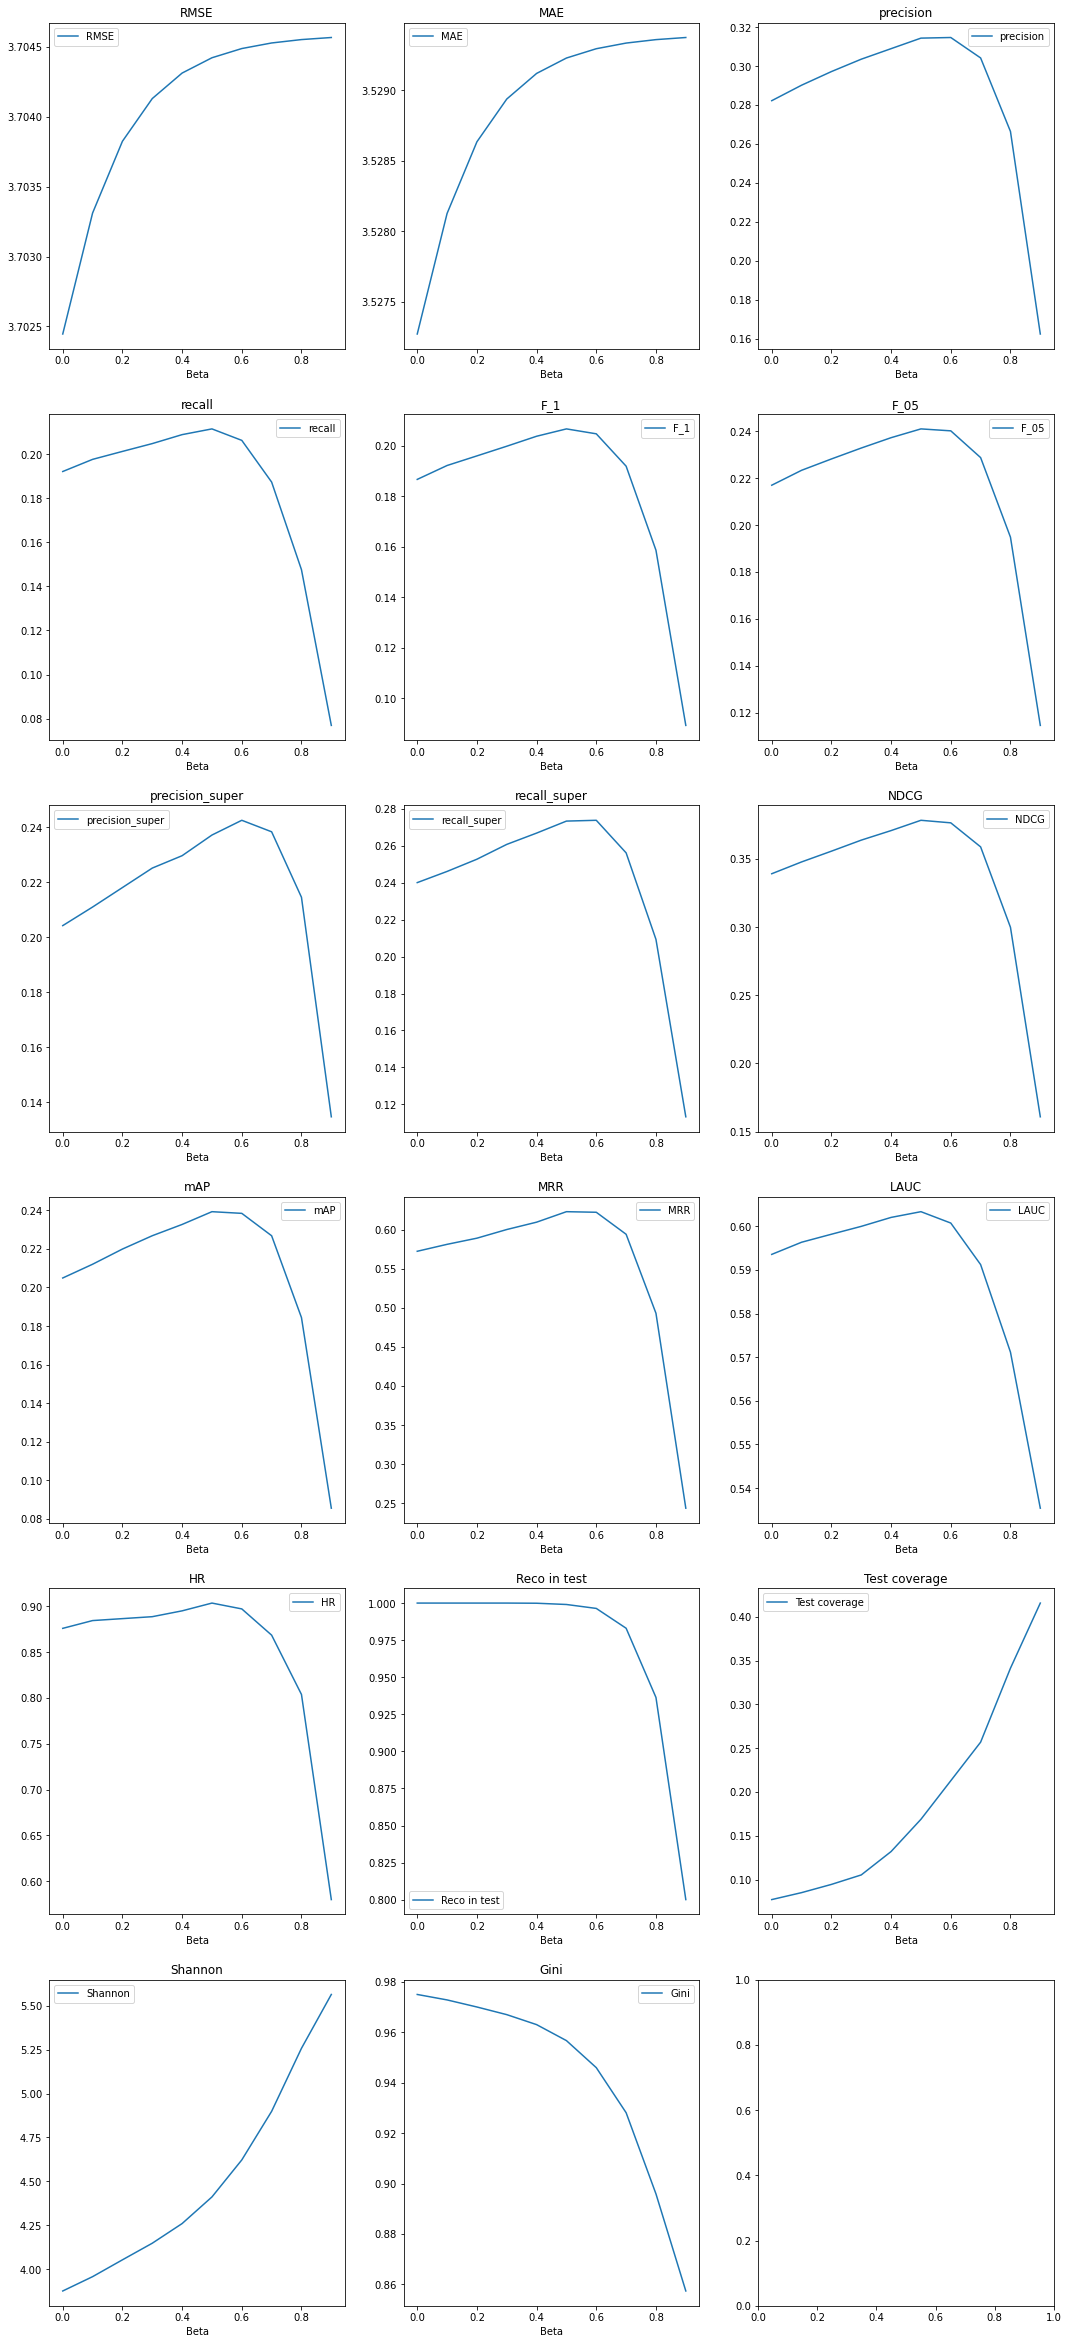

In [9]:
metrics = list(result.columns[[i not in ["Beta"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Beta", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [10]:
train = pd.read_csv(
    "./Datasets/ml-100k/train.csv",
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"],
)
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

user = random.choice(list(set(train["user"])))

train_content = pd.merge(train, items, left_on="item", right_on="id")
display(
    train_content[train_content["user"] == user][
        ["user", "rating", "title", "genres"]
    ].sort_values(by="rating", ascending=False)[:15]
)

reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

# Let's ignore scores - they are not used in evaluation:
reco_users = reco[:, :1]
reco_items = reco[:, 1::2]
# Let's put them into one array
reco = np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended = []
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb + 1, entry))
recommended = pd.DataFrame(recommended, columns=["user", "rec_nb", "item"])

recommended_content = pd.merge(recommended, items, left_on="item", right_on="id")
recommended_content[recommended_content["user"] == user][
    ["user", "rec_nb", "title", "genres"]
].sort_values(by="rec_nb")

user  rating                                   title  \
29798   853       5                        Soul Food (1997)   
26282   853       5                    Air Force One (1997)   
73991   853       4                  Fire Down Below (1997)   
24846   853       4                          Gattaca (1997)   
52746   853       4                    Fly Away Home (1996)   
46026   853       4                L.A. Confidential (1997)   
33394   853       4                        Game, The (1997)   
58732   853       4                          Volcano (1997)   
30970   853       4                         Rosewood (1997)   
55641   853       4                          Hoodlum (1997)   
19322   853       4                           Scream (1996)   
73653   853       4                     Gang Related (1997)   
20974   853       4  I Know What You Did Last Summer (1997)   
62996   853       3                   Kiss the Girls (1997)   
37091   853       3                          Contact (1997)   

                                    genres  
29798                                Drama  
26282                     Action, Thriller  
73991              Action, Drama, Thriller  
24846              Drama, Sci-Fi, Thriller  
52746                Adventure, Children's  
46026  Crime, Film-Noir, Mystery, Thriller  
33394                    Mystery, Thriller  
58732                      Drama, Thriller  
30970                                Drama  
55641              Crime, Drama, Film-Noir  
19322                     Horror, Thriller  
73653                                Crime  
20974            Horror, Mystery, Thriller  
62996               Crime, Drama, Thriller  
37091                        Drama, Sci-Fi

user  rec_nb                        title  \
5009  853.0       1               Titanic (1997)   
5225  853.0       2       Full Monty, The (1997)   
8911  853.0       3        Murder at 1600 (1997)   
3809  853.0       4           Chasing Amy (1997)   
380   853.0       5             Star Wars (1977)   
6337  853.0       6     Good Will Hunting (1997)   
2979  853.0       7    Return of the Jedi (1983)   
9039  853.0       8                 Evita (1996)   
9021  853.0       9  Seven Years in Tibet (1997)   
7296  853.0      10                 Fargo (1996)   

                                       genres  
5009                   Action, Drama, Romance  
5225                                   Comedy  
8911                        Mystery, Thriller  
3809                           Drama, Romance  
380   Action, Adventure, Romance, Sci-Fi, War  
6337                                    Drama  
2979  Action, Adventure, Romance, Sci-Fi, War  
9039                           Drama, Musical  
9021                               Drama, War  
7296                   Crime, Drama, Thriller

# project task 5: generate recommendations of RP3Beta for hyperparameters found to optimize recall

In [11]:
# We generated recommendations for P3, a special case of RP3Beta (with alpha=1, beta=0).
# We've observed that changing alpha and beta impacts the model performance.

# Your task is find values alpha and beta for which recall will be the highest 
# (any solution with recall higher than P3 will be accepted)
# train the model and generate recommendations.

# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

In [36]:
model = RP3Beta()
model.fit(train_ui, alpha=0.6, beta=0.6)

In [37]:
top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_RP3Beta_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv",
    index=False,
    header=False,
)

In [38]:
import evaluation_measures as ev

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_RP3Beta_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 12405.33it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.675385  3.499644   0.321209  0.212728  0.210025  0.245804   

   precision_super  recall_super     NDCG       mAP       MRR      LAUC  \
0         0.240021      0.275765  0.39005  0.252127  0.641583  0.604033   

         HR  HitRate2  HitRate3  Reco in test  Test coverage   Shannon  \
0  0.898197  0.725345  0.552492           1.0       0.157287  4.524904   

       Gini  
0  0.951442

# project task 6 (optional): implement graph-based model of your choice 

In [9]:
# for example change length of paths in RP3beta or make some other modification (but change more than input and hyperparameters)
# feel free to implement your idea or search for some ideas

# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'

In [10]:
class RP3Custom:
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui = train_ui
        self.train_iu = train_ui.transpose()

        self.alpha = alpha
        self.beta = beta

        # Define Pui
        Pui = sparse.csr_matrix(self.train_ui / self.train_ui.sum(axis=1))

        # Define Piu
        to_divide = np.vectorize(lambda x: x if x > 0 else 1)(
            self.train_iu.sum(axis=1)
        )  # to avoid dividing by zero
        Piu = sparse.csr_matrix(self.train_iu / to_divide)
        item_orders = (self.train_ui > 0).sum(axis=0)

        PuiAlfa = Pui.power(self.alpha)
        PiuAlfa = Piu.power(self.alpha)
        PuiBeta = Pui.power(self.beta)
        PiuBeta = Piu.power(self.beta)

        P3 = PuiAlfa * PiuAlfa * PuiAlfa * PuiBeta * PiuBeta

        P3 /= np.power(
            np.vectorize(lambda x: x if x > 0 else 1)(item_orders), self.beta
        )

        self.estimations = np.array(P3)

    def recommend(self, user_code_id, item_code_id, topK=10):

        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):

            user_rated = self.train_ui.indices[
                self.train_ui.indptr[nb_user] : self.train_ui.indptr[nb_user + 1]
            ]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result

    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append(
                [
                    user_code_id[user],
                    item_code_id[item],
                    self.estimations[user, item]
                    if not np.isnan(self.estimations[user, item])
                    else 1,
                ]
            )
        return result

In [12]:
myModel = RP3Custom()
model.fit(train_ui, alpha=0.8, beta=0.6)

top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_GraphTask_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_GraphTask_estimations.csv",
    index=False,
    header=False,
)

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_GraphTask_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_GraphTask_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 13313.77it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.702928  3.527713   0.322694  0.216069  0.212152  0.247538   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.245279      0.284983  0.388271  0.248239  0.636318  0.605683   

         HR  HitRate2  HitRate3  Reco in test  Test coverage   Shannon  \
0  0.910923  0.731707  0.554613      0.999788       0.178932  4.549663   

       Gini  
0  0.950182